In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


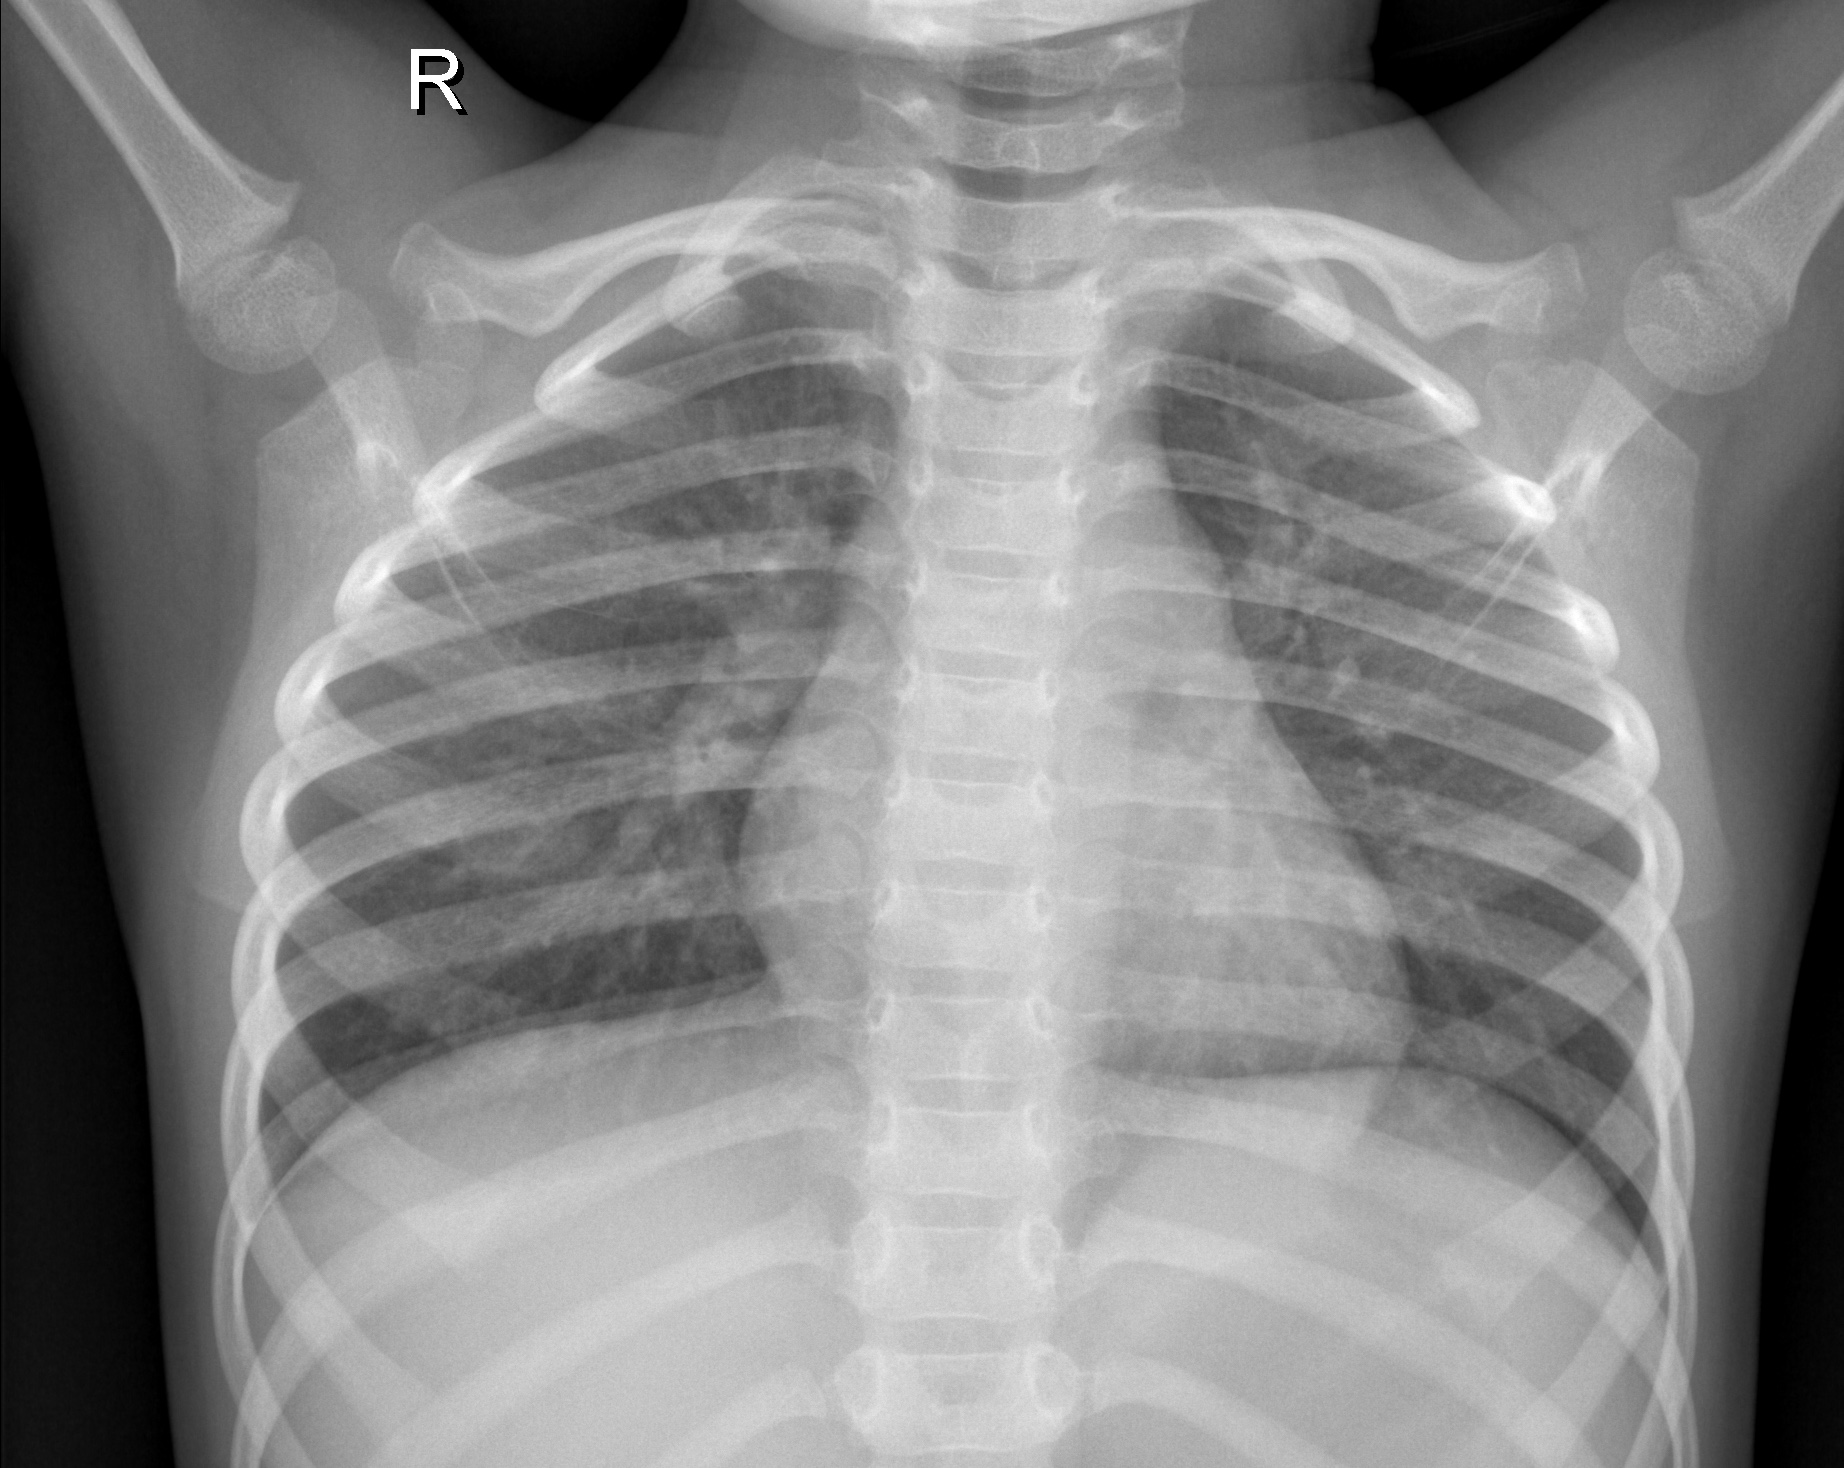

In [ ]:
# Make sure the images are there
from IPython.display import Image, display
display(Image(filename='/content/gdrive/MyDrive/chest_xray_new_again/train/NORMAL/IM-0242-0001.jpeg', width = 500))

In [ ]:
# Download and import libraries
!pip install torch torchvision 
#matplotlib numpy scikit-image pillow==4.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install matplotlib numpy 
#scikit-image pillow==4.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install pillow==4.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.3 MB 21.5 MB/s 
     |████████████████████████████████| 112 kB 59.0 MB/s 
ERROR: Operation cancelled by user


In [ ]:
! pip install scikit-image 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time

In [ ]:
use_gpu=torch.cuda.is_available()

In [ ]:
# Check if GPU is available
use_gpu = torch.cuda.is_available()

In [ ]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

In [ ]:
model = ColorizationNet()

In [ ]:
criterion = nn.MSELoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

In [ ]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target

In [ ]:
# Training
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder_normal = GrayscaleImageFolder('/content/gdrive/MyDrive/chest_xray_new_again/train', train_transforms)
# train_imagefolder_pneumonia = GrayscaleImageFolder('/content/gdrive/MyDrive/chest_xray/train', train_transforms)
train_loader_normal = torch.utils.data.DataLoader(train_imagefolder_normal, batch_size=64, shuffle=True)
# train_loader_pnuemonia = torch.utils.data.DataLoader(train_imagefolder_pneumonia, batch_size=64, shuffle=True)

# Validation 
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder_normal = GrayscaleImageFolder('/content/gdrive/MyDrive/chest_xray_new_again/val' , val_transforms)
# val_imagefolder_pnuemonia = GrayscaleImageFolder('/content/gdrive/MyDrive/chest_xray/val' , val_transforms)
val_loader_normal = torch.utils.data.DataLoader(val_imagefolder_normal, batch_size=64, shuffle=False)
# val_loader_pnuemonia = torch.utils.data.DataLoader(val_imagefolder_pnuemonia, batch_size=64, shuffle=False)

In [ ]:
train_imagefolder_normal

Dataset GrayscaleImageFolder
    Number of datapoints: 400
    Root location: /content/gdrive/MyDrive/chest_xray_new_again/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
           )

In [ ]:
len(val_loader_normal)

2

In [ ]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [ ]:
def validate(val_loader, model, criterion, save_images, epoch, validate_losses):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))
    validate_losses.append(loss.item())

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg, validate_losses

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, train_losses):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))
    train_losses.append(loss.item())

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))

In [ ]:
# Move model and loss function to GPU
if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()

In [ ]:
# Make folders and set parameters
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 15

In [ ]:
len(train_loader_normal)

7

In [ ]:
# Train model
for epoch in range(epochs):
  # Train for one epoch, then validate
  train_losses = []
  train(train_loader_normal, model, criterion, optimizer, epoch, train_losses)
  # train(train_loader_pnuemonia, model, criterion, optimizer, epoch)
  with torch.no_grad():
    validate_losses = []
    losses_normal, validate_losses = validate(val_loader_normal, model, criterion, save_images, epoch, validate_losses)
    # losses_pneumonia = validate(val_loader_pnuemonia, model, criterion, save_images, epoch)
  # Save checkpoint and replace old best model if current model is better
  if losses_normal < best_losses:
    best_losses = losses_normal
    torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses_normal))
  # if losses_pneumonia < best_losses:
    # best_losses = losses_pneumonia
    # torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses_pneumonia))

Starting training epoch 0
Epoch: [0][0/7]	Time 1.983 (1.983)	Data 1.894 (1.894)	Loss 0.3909 (0.3909)	
Finished training epoch 0


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 49740 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 49728 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 49744 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 49736 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/2]	Time 2.169 (2.169)	Loss 1819405.5000 (1819405.5000)	
Finished validation.
Starting training epoch 1
Epoch: [1][0/7]	Time 1.887 (1.887)	Data 1.802 (1.802)	Loss 0.0096 (0.0096)	
Finished training epoch 1


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 43448 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 16184 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 49551 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 40529 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 40803 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: Use

Validate: [0/2]	Time 2.195 (2.195)	Loss 789.4319 (789.4319)	
Finished validation.
Starting training epoch 2
Epoch: [2][0/7]	Time 1.939 (1.939)	Data 1.854 (1.854)	Loss 0.0105 (0.0105)	
Finished training epoch 2


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 5954 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 11330 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 21261 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 5142 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2663 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWa

Validate: [0/2]	Time 2.165 (2.165)	Loss 1.4897 (1.4897)	
Finished validation.
Starting training epoch 3
Epoch: [3][0/7]	Time 1.947 (1.947)	Data 1.862 (1.862)	Loss 0.0043 (0.0043)	
Finished training epoch 3


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 10445 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/2]	Time 2.136 (2.136)	Loss 0.0294 (0.0294)	
Finished validation.
Starting training epoch 4
Epoch: [4][0/7]	Time 1.829 (1.829)	Data 1.743 (1.743)	Loss 0.0145 (0.0145)	
Finished training epoch 4
Validate: [0/2]	Time 2.171 (2.171)	Loss 0.0033 (0.0033)	
Finished validation.
Starting training epoch 5
Epoch: [5][0/7]	Time 1.844 (1.844)	Data 1.760 (1.760)	Loss 0.0029 (0.0029)	
Finished training epoch 5
Validate: [0/2]	Time 2.152 (2.152)	Loss 0.0082 (0.0082)	
Finished validation.
Starting training epoch 6
Epoch: [6][0/7]	Time 1.874 (1.874)	Data 1.790 (1.790)	Loss 0.0018 (0.0018)	
Finished training epoch 6
Validate: [0/2]	Time 2.150 (2.150)	Loss 0.0009 (0.0009)	
Finished validation.
Starting training epoch 7
Epoch: [7][0/7]	Time 1.857 (1.857)	Data 1.772 (1.772)	Loss 0.0017 (0.0017)	
Finished training epoch 7
Validate: [0/2]	Time 2.183 (2.183)	Loss 0.0023 (0.0023)	
Finished validation.
Starting training epoch 8
Epoch: [8][0/7]	Time 1.828 (1.828)	Data 1.743 (1.743)	Loss 0.0014 (0.001

<Figure size 432x288 with 0 Axes>

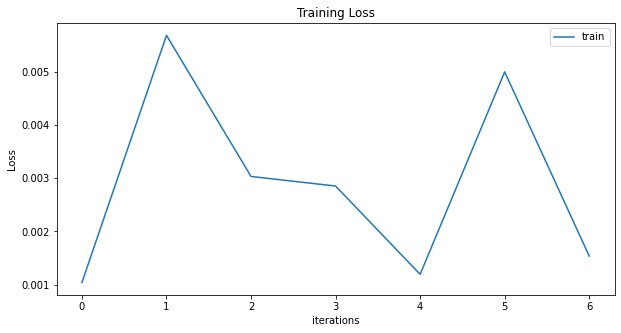

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

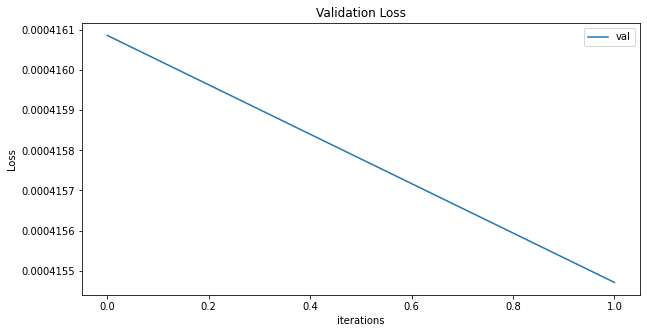

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation Loss")
plt.plot(validate_losses,label="val")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

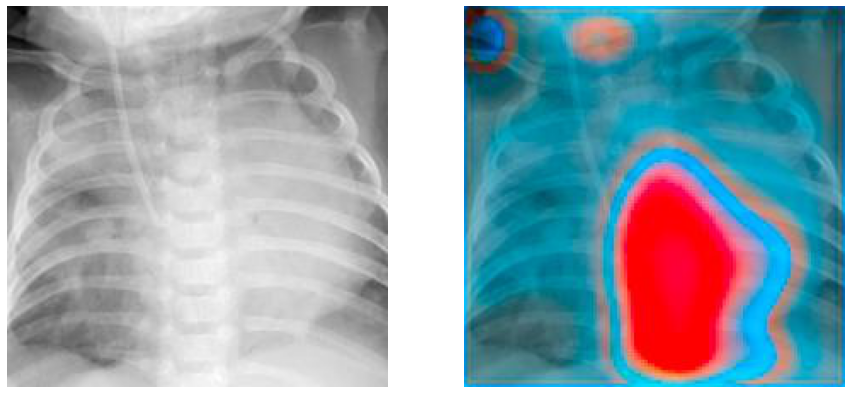

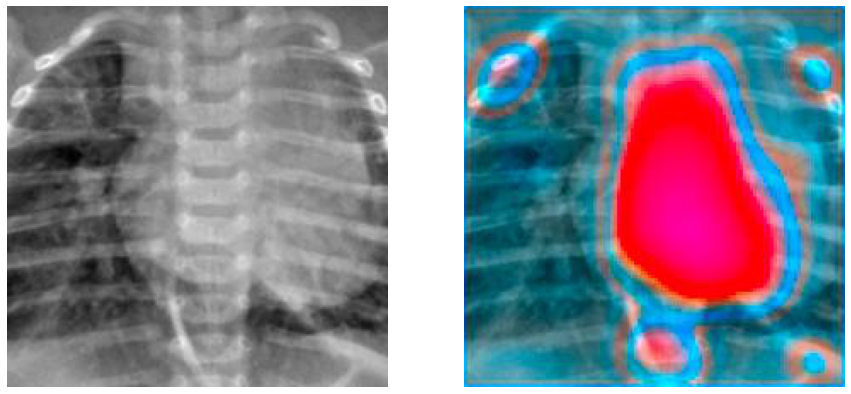

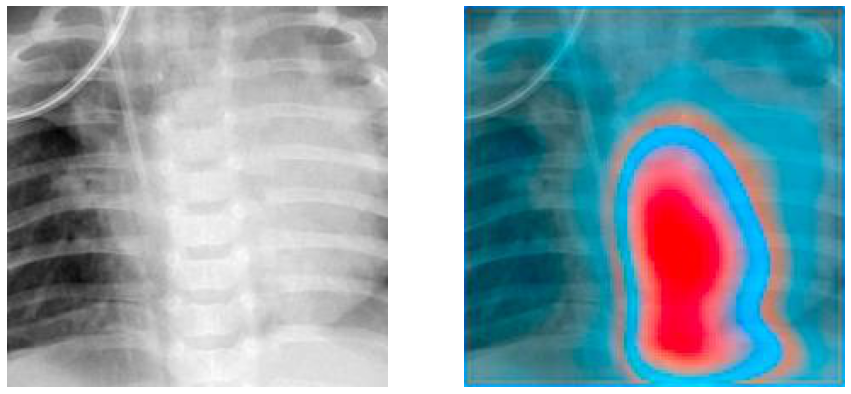

In [ ]:
# Show images 
import matplotlib.image as mpimg
image_pairs = [
               ('/content/outputs/color/img-6-epoch-2.jpg', '/content/outputs/gray/img-6-epoch-2.jpg'),
               ('/content/outputs/color/img-0-epoch-2.jpg', '/content/outputs/gray/img-0-epoch-2.jpg'),
                ('/content/outputs/color/img-3-epoch-2.jpg', '/content/outputs/gray/img-3-epoch-2.jpg')
               ]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()